In [1]:
## Automl with ersilia embeddings
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, classification_report
import flaml
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
# Load the model
model_path = '../../checkpoints/AutoML_ersilia.joblib'
AutoML_model = joblib.load(model_path)

In [3]:
# Load the TDC dataset
tdc_data_path = '../data/filtered_tdc_dataset.csv'
tdc_data = pd.read_csv(tdc_data_path)

In [4]:
##Convert SMILES to Ersilia Embeddings:

from eosce.models import ErsiliaCompoundEmbeddings

# Assuming 'SMILES' is the column containing chemical compounds in your TDC dataset
tdc_compounds = tdc_data['Drug'].tolist()

# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()

# Create a new column for embeddings
tdc_data['embeddings'] = tdc_data['Drug'].apply(lambda x: model.transform([x])[0])


# Assuming preprocess_data is your data preprocessing function
X_tdc = tdc_data['embeddings']

In [5]:
print(X_tdc)

0      [0.05109995, -0.034270585, -0.04409432, 0.0693...
1      [-0.046583306, -0.044300105, 0.06653848, -0.00...
2      [-0.022244511, -0.049714245, 0.00392899, 0.120...
3      [0.038444757, -0.12525988, -0.011432024, 0.039...
4      [-0.09020368, 0.11691403, 0.11882201, 0.053132...
                             ...                        
403    [0.09199667, -0.071337305, 0.011969814, 0.0772...
404    [0.05699184, -0.015053667, -0.047389545, -0.05...
405    [0.10620239, -0.007281141, -0.25737908, -0.014...
406    [0.03251487, 0.02081342, 0.0010510255, -0.0059...
407    [0.09114363, -0.00090367626, -0.22689229, -0.0...
Name: embeddings, Length: 408, dtype: object


In [6]:
X_tdc = np.array(tdc_data['embeddings'].tolist())

AUC on TDC dataset: 0.825925925925926


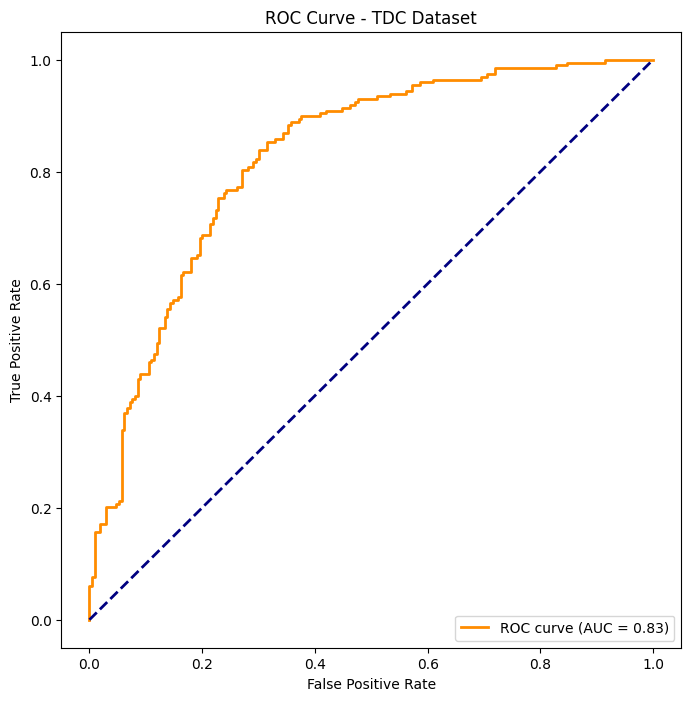

In [7]:
# Predict probabilities for the positive class
tdc_predictions_proba = AutoML_model.predict_proba(X_tdc)[:, 1]

# Assuming you have the true labels in 'Target' column
# Calculate ROC curve and AUC
fpr_tdc, tpr_tdc, thresholds_tdc = roc_curve(tdc_data['Y'], tdc_predictions_proba)
auc_tdc = auc(fpr_tdc, tpr_tdc)

print(f"AUC on TDC dataset: {auc_tdc}")

# Optionally, visualize the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(fpr_tdc, tpr_tdc, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tdc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TDC Dataset')
plt.legend(loc="lower right")
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate classification report
classification_rep = classification_report(true_labels, tdc_predictions)

# Print the classification report
print("Classification Report on TDC dataset:")
print(classification_rep)

Classification Report on TDC dataset:
              precision    recall  f1-score   support

         0.0       0.95      0.28      0.43       210
         1.0       0.56      0.98      0.72       198

    accuracy                           0.62       408
   macro avg       0.76      0.63      0.57       408
weighted avg       0.76      0.62      0.57       408



In [9]:
from sklearn.metrics import confusion_matrix

# Assuming you have true labels in 'Y' column
true_labels = tdc_data['Y']

# Set a threshold for binary classification (if needed)
threshold = 0.5  # Adjust this threshold based on your specific requirements

# Assuming you have predictions in 'tdc_predictions_proba'
tdc_predictions = (tdc_predictions_proba > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, tdc_predictions)

# Print the confusion matrix
print("Confusion Matrix on TDC dataset:")
print(conf_matrix)


Confusion Matrix on TDC dataset:
[[ 58 152]
 [  3 195]]


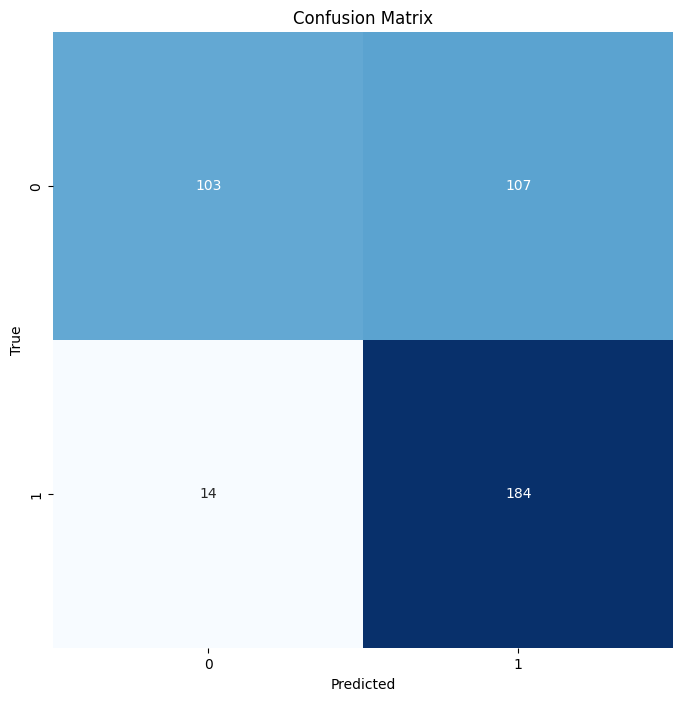

In [27]:
##Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'outcome' is the name of the Series containing predicted outcomes
tdc_predictions = tdc_predictions

# Calculate confusion matrix
cm = confusion_matrix(tdc_true_labels, tdc_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
